In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, img_size=320, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.transform = transform or transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

        self.image_files = sorted([
            f for f in os.listdir(image_dir) 
            if f.endswith(".jpg") or f.endswith(".png")
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + ".txt")

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        h, w = self.img_size, self.img_size

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    cls, x_c, y_c, bw, bh = map(float, line.strip().split())
                   
                    x1 = (x_c - bw / 2) * w
                    y1 = (y_c - bh / 2) * h
                    x2 = (x_c + bw / 2) * w
                    y2 = (y_c + bh / 2) * h
                    boxes.append([x1, y1, x2, y2, int(cls)])

        target = torch.tensor(boxes, dtype=torch.float32)
        return image, target


In [3]:
def plot_image_with_boxes(image_tensor, boxes_tensor, class_names=None):
    img = image_tensor.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    ax = plt.gca()
    
    for box in boxes_tensor:
        x1, y1, x2, y2, cls = box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             edgecolor='red', linewidth=2, facecolor='none')
        ax.add_patch(rect)
        label = f"{int(cls)}" if class_names is None else class_names[int(cls)]
        ax.text(x1, y1 - 5, label, color='white',
                bbox=dict(facecolor='red', alpha=0.5), fontsize=10)

    plt.axis("off")
    plt.show()


Image 0 → Boxes: 2


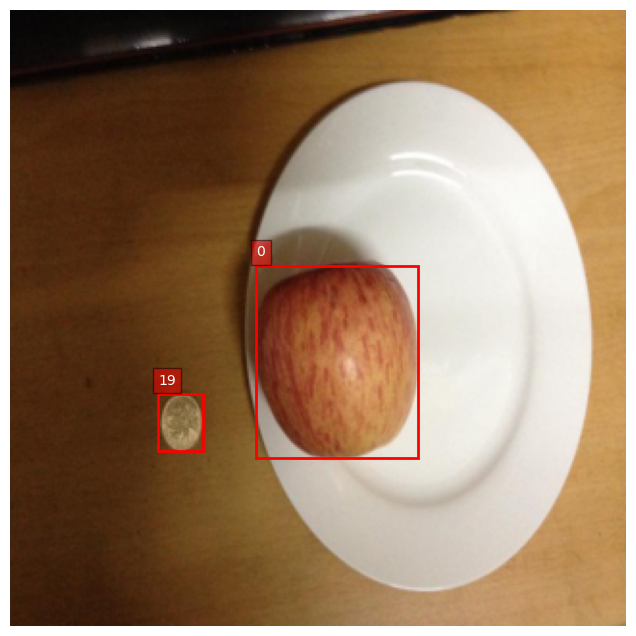

Image 1 → Boxes: 2


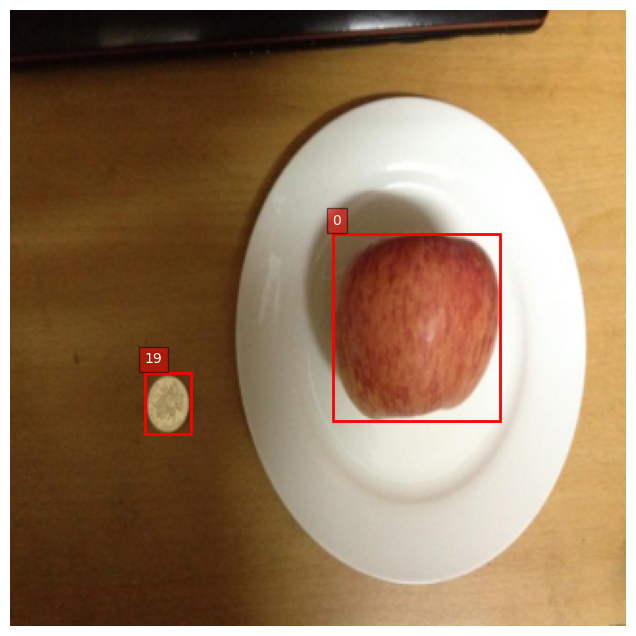

Image 2 → Boxes: 2


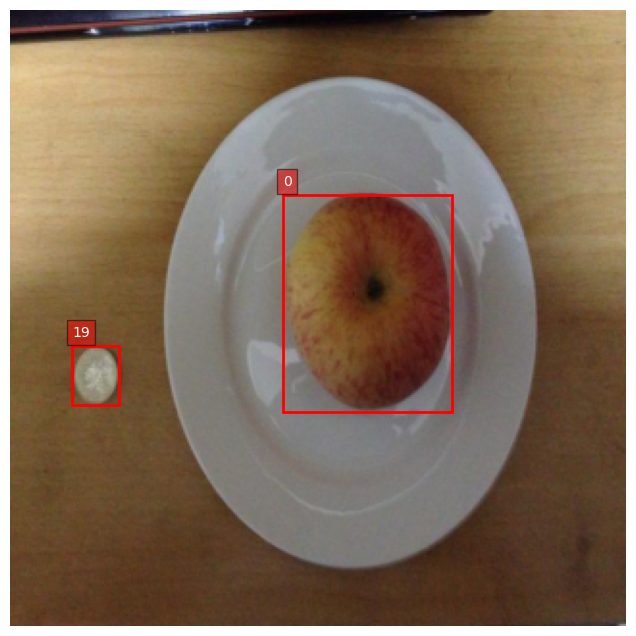

In [4]:
image_dir = "ecust_dataset/images/train"
label_dir = "ecust_dataset/labels/train"
train_dataset = YoloDataset(image_dir, label_dir)

for i in range(3):
    img, boxes = train_dataset[i]
    print(f"Image {i} → Boxes: {boxes.shape[0]}")
    plot_image_with_boxes(img, boxes)

In [5]:
class YoloNet(nn.Module):
    def __init__(self, num_classes=20, num_anchors=3, grid_size=20):
        super(YoloNet, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.grid_size = grid_size
        self.out_channels = num_anchors * (5 + num_classes)  

        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  
        )

        self.head = nn.Conv2d(256, self.out_channels, kernel_size=1)

    def forward(self, x):
        x = self.backbone(x)  
        x = self.head(x)      
        x = x.view(x.size(0), self.num_anchors, 5 + self.num_classes,
                   self.grid_size, self.grid_size)
        x = x.permute(0, 1, 3, 4, 2).contiguous()  
        return x


In [6]:
model = YoloNet(num_classes=20).to(device)
dummy_input = torch.randn(2, 3, 320, 320).to(device)
output = model(dummy_input)
print(output.shape) 

torch.Size([2, 3, 20, 20, 25])


In [7]:
import torch.nn as nn
import torch

class YoloLoss(nn.Module):
    def __init__(self, lambda_box=5.0, lambda_obj=1.0, lambda_noobj=0.5, lambda_cls=1.0, debug=False):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='mean')
        self.bce = nn.BCELoss(reduction='mean')
        self.ce = nn.CrossEntropyLoss(reduction='mean')
        self.lambda_box = lambda_box
        self.lambda_obj = lambda_obj
        self.lambda_noobj = lambda_noobj
        self.lambda_cls = lambda_cls
        self.debug = debug

    def forward(self, preds, targets):
        
        obj_mask = targets[..., 4] == 1
        noobj_mask = targets[..., 4] == 0

        
        box_loss = self.mse(preds[..., 0:4][obj_mask], targets[..., 0:4][obj_mask])

       
        pred_obj = torch.sigmoid(preds[..., 4])
        obj_loss = self.bce(pred_obj[obj_mask], targets[..., 4][obj_mask])
        noobj_loss = self.bce(pred_obj[noobj_mask], targets[..., 4][noobj_mask])

        
        if targets.shape[-1] > 5 and obj_mask.sum() > 0:
            pred_cls = preds[..., 5:][obj_mask]
            target_cls = targets[..., 5:][obj_mask].argmax(dim=-1).long()
            cls_loss = self.ce(pred_cls, target_cls)
        else:
            cls_loss = torch.tensor(0.0, device=preds.device)

        
        total_loss = (
            self.lambda_box * box_loss +
            self.lambda_obj * obj_loss +
            self.lambda_noobj * noobj_loss +
            self.lambda_cls * cls_loss
        )

        if self.debug:
            print(f"Loss Breakdown → box: {box_loss.item():.4f} | obj: {obj_loss.item():.4f} | noobj: {noobj_loss.item():.4f} | cls: {cls_loss.item():.4f} | total: {total_loss.item():.4f}")

        return total_loss


In [8]:
def build_target(targets, anchors, S=20, num_classes=20, image_size=320):
    
    B = len(targets)
    A = len(anchors)
    target_tensor = torch.zeros((B, A, S, S, 5 + num_classes))

    cell_size = image_size / S
    anchors = torch.tensor(anchors)

    for b in range(B):
        for box in targets[b]:
            x1, y1, x2, y2, cls = box
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2
            w = x2 - x1
            h = y2 - y1

            grid_x = int(cx / cell_size)
            grid_y = int(cy / cell_size)

            if grid_x >= S or grid_y >= S:
                continue

            
            cell_cx = (cx / image_size) * S - grid_x
            cell_cy = (cy / image_size) * S - grid_y
            box_w = w / image_size
            box_h = h / image_size

            
            ious = []
            for i, (aw, ah) in enumerate(anchors):
                iou = (min(box_w, aw) * min(box_h, ah)) / (box_w * box_h + aw * ah - min(box_w, aw) * min(box_h, ah) + 1e-6)
                ious.append(iou)
            best_anchor = torch.argmax(torch.tensor(ious))

            
            target_tensor[b, best_anchor, grid_y, grid_x, 0:4] = torch.tensor([cell_cx, cell_cy, box_w, box_h])
            target_tensor[b, best_anchor, grid_y, grid_x, 4] = 1.0  
            target_tensor[b, best_anchor, grid_y, grid_x, 5 + int(cls)] = 1.0

    return target_tensor


In [9]:
anchors = [[0.1, 0.1], [0.2, 0.3], [0.4, 0.4]]

target_batch = [torch.tensor([[60, 60, 120, 120, 0], [240, 250, 300, 300, 19]])]

yolo_targets = build_target(target_batch, anchors, S=20, num_classes=20, image_size=320)
print(yolo_targets.shape)


torch.Size([1, 3, 20, 20, 25])


In [10]:
def train_model(model, dataloader, anchors, optimizer, criterion,
                num_classes=20, image_size=320, num_epochs=10, device='cuda'):
    log = []

    model = model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        pos_correct = 0
        pos_total = 0
        neg_correct = 0
        neg_total = 0

        for imgs, targets in dataloader:
            imgs = torch.stack(imgs).to(device)

            target_tensor = build_target(
                targets, anchors,
                S=20, num_classes=num_classes, image_size=image_size
            ).to(device)

            preds = model(imgs)

            loss = criterion(preds, target_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            
            pred_obj = (torch.sigmoid(preds[..., 4]) > 0.5).float()
            true_obj = target_tensor[..., 4]

           
            pos_mask = true_obj == 1
            pos_correct += (pred_obj[pos_mask] == 1).sum().item()
            pos_total += pos_mask.sum().item()

           
            neg_mask = true_obj == 0
            neg_correct += (pred_obj[neg_mask] == 0).sum().item()
            neg_total += neg_mask.sum().item()

        avg_loss = total_loss / len(dataloader)
        pos_acc = (pos_correct / pos_total) * 100 if pos_total > 0 else 0.0
        neg_acc = (neg_correct / neg_total) * 100 if neg_total > 0 else 0.0
        log.append((epoch, avg_loss, pos_acc, neg_acc))

        print(f"Epoch {epoch:02d} | Loss: {avg_loss:.4f} | Pos Acc: {pos_acc:.2f}% | Neg Acc: {neg_acc:.2f}%")

    return log


In [11]:
from torch.utils.data import DataLoader

batch_size = 4
image_size = 320

train_dataset = YoloDataset(
    image_dir="ecust_dataset/images/train",
    label_dir="ecust_dataset/labels/train",
    img_size=image_size
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda b: tuple(zip(*b))
)


In [12]:
model = YoloNet(num_classes=20, num_anchors=3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = YoloLoss(debug=False)

In [13]:
log = train_model(
    model=model,
    dataloader=train_loader,
    anchors=anchors,
    optimizer=optimizer,
    criterion=criterion,
    num_classes=20,
    image_size=320,
    num_epochs=100,  
    device=device
)

Epoch 01 | Loss: 2.2533 | Pos Acc: 92.48% | Neg Acc: 61.36%
Epoch 02 | Loss: 1.2876 | Pos Acc: 94.77% | Neg Acc: 82.29%
Epoch 03 | Loss: 1.0431 | Pos Acc: 94.54% | Neg Acc: 85.67%
Epoch 04 | Loss: 0.8746 | Pos Acc: 95.65% | Neg Acc: 87.76%
Epoch 05 | Loss: 0.7414 | Pos Acc: 96.28% | Neg Acc: 90.00%
Epoch 06 | Loss: 0.6504 | Pos Acc: 96.12% | Neg Acc: 90.56%
Epoch 07 | Loss: 0.5758 | Pos Acc: 96.67% | Neg Acc: 91.35%
Epoch 08 | Loss: 0.4975 | Pos Acc: 97.94% | Neg Acc: 92.42%
Epoch 09 | Loss: 0.4771 | Pos Acc: 97.55% | Neg Acc: 92.92%
Epoch 10 | Loss: 0.4392 | Pos Acc: 98.18% | Neg Acc: 93.32%
Epoch 11 | Loss: 0.4006 | Pos Acc: 98.26% | Neg Acc: 93.61%
Epoch 12 | Loss: 0.3543 | Pos Acc: 98.81% | Neg Acc: 94.58%
Epoch 13 | Loss: 0.3242 | Pos Acc: 98.50% | Neg Acc: 95.00%
Epoch 14 | Loss: 0.2990 | Pos Acc: 99.13% | Neg Acc: 95.32%
Epoch 15 | Loss: 0.2869 | Pos Acc: 98.89% | Neg Acc: 95.55%
Epoch 16 | Loss: 0.2738 | Pos Acc: 98.97% | Neg Acc: 94.98%
Epoch 17 | Loss: 0.2480 | Pos Acc: 99.05

In [30]:
import torch
import torchvision.ops as ops

def predict_yolo(
    model,
    image_tensor,
    anchors,
    conf_thresh=0.6,
    class_conf_thresh=0.5,
    iou_thresh=0.3,
    max_boxes=10,
    image_size=320,
    num_classes=20,
):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to(next(model.parameters()).device))[0].cpu()

    A = output.shape[0]  # num anchors
    S = output.shape[1]  # grid size
    C = num_classes

    boxes = []
    scores = []
    class_ids = []

    best_per_cell = {}  

    for a in range(A):
        for i in range(S):
            for j in range(S):
                pred = output[a, i, j]
                obj_score = torch.sigmoid(pred[4])
                if obj_score < conf_thresh:
                    continue

                class_probs = torch.softmax(pred[5:], dim=0)
                class_id = torch.argmax(class_probs).item()
                class_score = class_probs[class_id].item()
                final_score = obj_score.item() * class_score

                if final_score < class_conf_thresh:
                    continue

                key = (i, j, class_id)
                if key not in best_per_cell or final_score > best_per_cell[key][0]:
                    cx = (torch.sigmoid(pred[0]) + j) / S
                    cy = (torch.sigmoid(pred[1]) + i) / S
                    w = anchors[a][0] * torch.exp(pred[2])
                    h = anchors[a][1] * torch.exp(pred[3])
                    x1 = (cx - w / 2) * image_size
                    y1 = (cy - h / 2) * image_size
                    x2 = (cx + w / 2) * image_size
                    y2 = (cy + h / 2) * image_size
                    best_per_cell[key] = (final_score, [x1, y1, x2, y2], class_id)

    boxes = torch.tensor([v[1] for v in best_per_cell.values()])
    scores = torch.tensor([v[0] for v in best_per_cell.values()])
    class_ids = [v[2] for v in best_per_cell.values()]

    if boxes.shape[0] == 0:
        return [], [], []

   
    keep = ops.nms(boxes, scores, iou_thresh)
    keep = keep[:max_boxes]

    boxes = boxes[keep]
    scores = scores[keep]
    class_ids = [class_ids[i] for i in keep]

    return boxes.tolist(), scores.tolist(), class_ids


In [58]:
from PIL import Image
from torchvision import transforms

image_path = "ecust_dataset/images/test/apple017T(11).jpg" 

image = Image.open(image_path).convert("RGB").resize((320, 320))
img_tensor = transforms.ToTensor()(image)

boxes, scores, class_ids = predict_yolo(
    model=model,
    image_tensor=img_tensor,
    anchors=anchors,
    conf_thresh=0.6,
    class_conf_thresh=0.7,
    iou_thresh=0.3,
    max_boxes=2
)

In [59]:
import matplotlib.pyplot as plt

def draw_boxes_on_image(image_path, boxes, scores, class_ids, class_names=None):
    image = Image.open(image_path).convert("RGB").resize((320, 320))
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             edgecolor='red', linewidth=2, facecolor='none')
        ax.add_patch(rect)

        cls = class_ids[i]
        label = f"{cls}" if class_names is None else class_names[cls]
        ax.text(x1, y1 - 5, f"{label}: {scores[i]:.2f}",
                color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis("off")
    plt.title("Predictions")
    plt.show()


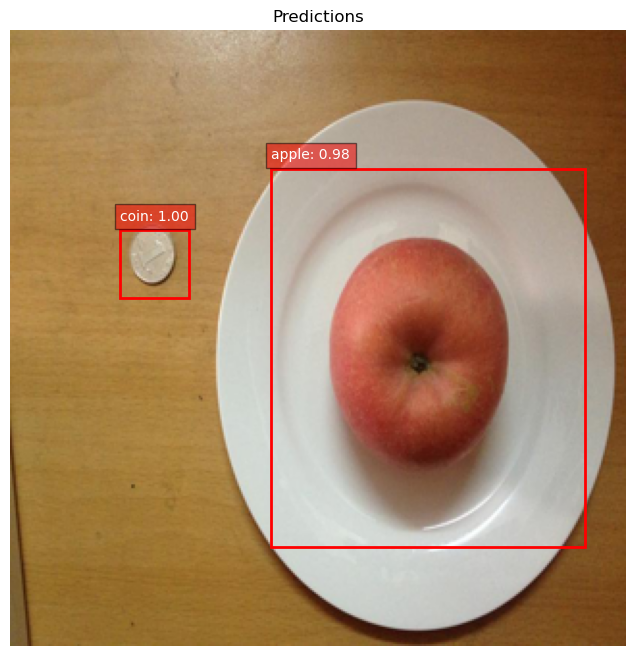

In [60]:
class_names = [
    "apple", "banana", "bread", "bun", "doughnut", "egg", "fired_dough_twist",
    "grape", "lemon", "litchi", "mango", "mooncake", "orange", "pear", "peach",
    "plum", "qiwi", "sachima", "tomato", "coin"
]

draw_boxes_on_image(image_path, boxes, scores, class_ids, class_names)


In [18]:
torch.save(model.state_dict(), "yolo_from_scratch.pth")

In [19]:
import torch

model = YoloNet(num_classes=20, num_anchors=3)

model.load_state_dict(torch.load("yolo_from_scratch.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

YoloNet(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(2

In [20]:
anchors = [[0.1, 0.1], [0.2, 0.3], [0.4, 0.4]]
image_size = 320

class_names = [
    "apple", "banana", "bread", "bun", "doughnut", "egg", "fired_dough_twist",
    "grape", "lemon", "litchi", "mango", "mooncake", "orange", "pear", "peach",
    "plum", "qiwi", "sachima", "tomato", "coin"
]


In [21]:
import matplotlib.pyplot as plt

def plot_training_log(log):
    
    epochs = [entry[0] for entry in log]
    losses = [entry[1] for entry in log]
    pos_accs = [entry[2] for entry in log]
    neg_accs = [entry[3] for entry in log]

    plt.figure(figsize=(14, 5))

    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, color='red', marker='o', label='Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.grid(True)
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, pos_accs, color='blue', marker='o', label='Positive Accuracy')
    plt.plot(epochs, neg_accs, color='green', marker='x', label='Negative Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Objectness Accuracy per Epoch")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


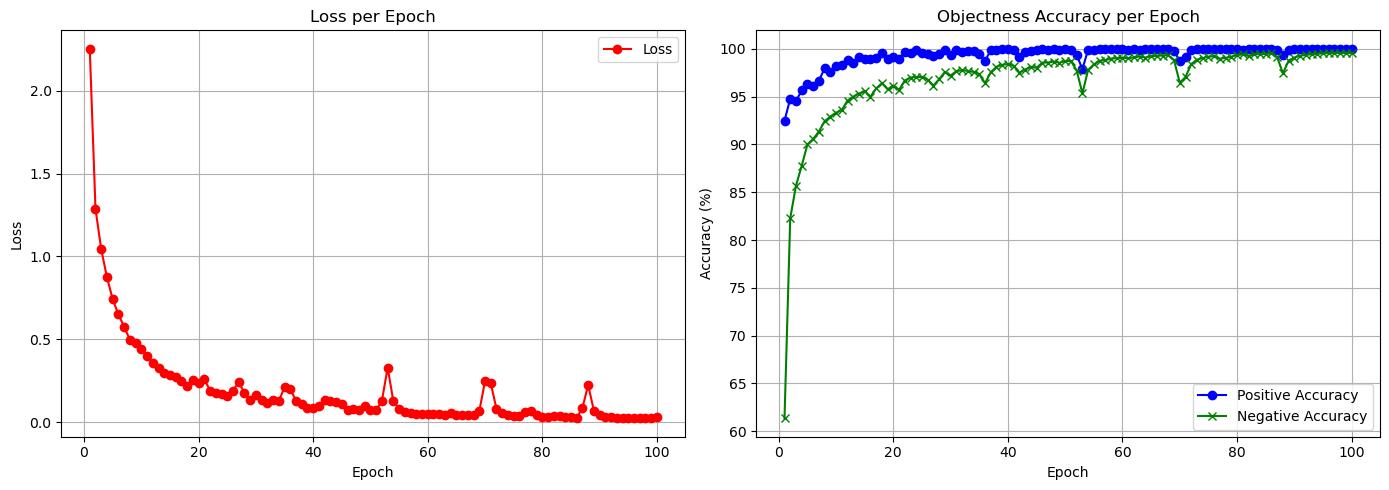

In [22]:
plot_training_log(log)

In [23]:
import csv

with open("training_log.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Loss", "Positive Accuracy", "Negative Accuracy"])
    writer.writerows(log)


In [61]:
import torch
from torch.utils.data import DataLoader
from torchvision.ops import box_iou
from collections import defaultdict
import numpy as np
from tqdm import tqdm


In [62]:
test_dataset = YoloDataset(
    image_dir="ecust_dataset/images/test",
    label_dir="ecust_dataset/labels/test",
    img_size=320
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda b: tuple(zip(*b))
)

In [63]:
def compute_ap(recall, precision):
    recall = np.concatenate(([0.], recall, [1.]))
    precision = np.concatenate(([0.], precision, [0.]))

    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])

    indices = np.where(recall[1:] != recall[:-1])[0]
    return np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])


In [64]:
all_predictions = defaultdict(list)
all_gts = defaultdict(list)

iou_thresh = 0.5

model.eval()
for images, targets in tqdm(test_loader):
    image = images[0]
    target = targets[0].to("cpu")
    
    boxes_pred, scores, class_ids = predict_yolo(model, image, anchors, iou_thresh=0.5)

    for i in range(len(boxes_pred)):
        cls = class_ids[i]
        all_predictions[cls].append({
            "box": boxes_pred[i],
            "score": scores[i],
            "image_id": id(image),
            "matched": False
        })

    for box in target:
        x1, y1, x2, y2, cls = box
        all_gts[int(cls)].append({
            "box": torch.tensor([x1, y1, x2, y2]),
            "image_id": id(image),
            "detected": False
        })


100%|██████████| 1733/1733 [01:21<00:00, 21.31it/s]


In [68]:
ap_scores = []
total_tp, total_fp, total_fn = 0, 0, 0

for cls in range(20):  
    preds = sorted(all_predictions[cls], key=lambda x: x["score"], reverse=True)
    gts = all_gts[cls]

    for gt in gts:
        gt["detected"] = False

    tp = np.zeros(len(preds))
    fp = np.zeros(len(preds))

    for i, pred in enumerate(preds):
        matched = False
        pred_box = torch.tensor(pred["box"]) if not isinstance(pred["box"], torch.Tensor) else pred["box"]

        for gt in gts:
            if gt["image_id"] == pred["image_id"] and not gt["detected"]:
                gt_box = torch.tensor(gt["box"]) if not isinstance(gt["box"], torch.Tensor) else gt["box"]
                iou = box_iou(pred_box.unsqueeze(0), gt_box.unsqueeze(0))[0][0].item()

                if iou >= iou_thresh:
                    tp[i] = 1
                    gt["detected"] = True
                    matched = True
                    break

        if not matched:
            fp[i] = 1

    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recalls = tp_cum / (len(gts) + 1e-6)
    precisions = tp_cum / (tp_cum + fp_cum + 1e-6)

    ap = compute_ap(recalls, precisions)
    ap_scores.append(ap)

    total_tp += int(tp.sum())
    total_fp += int(fp.sum())
    total_fn += len(gts) - int(tp.sum())

precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)
map_50 = np.mean(ap_scores)

print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"mAP@0.5   : {map_50:.4f}")

Precision : 0.4019
Recall    : 0.5968
F1 Score  : 0.4804
mAP@0.5   : 0.1891
